# this notebook tries to validate the thermal model - all C rate on
# split into 2: one for double and one for single

In [1]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing;import pandas as pd;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [3]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
# BasicPath = "C:/Users/rl1120/OneDrive - Imperial College London/"  #
BasicPath= "D:/OneDrive - Imperial College London/SimDataSave/P3R13/Validation/"
Target  = 'NonDs_Rcontact/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [4]:
# define parameter of double and single 
Para_dict_Same = {
   ################################# Same for single and double:
   "Mesh list":[ [10,5,10,60,30], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   # solvent diffusion parameters:
   "EC initial concentration in electrolyte [mol.m-3]":[3500],
   "Typical EC concentration [mol.m-3]":[3500,],
   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   "Negative electrode diffusivity [m2.s-1]":[
      "graphite_LGM50_diffusivity_ORegan2022",],     # 3.3e-14
   "Positive electrode diffusivity [m2.s-1]":[
      "nmc_LGM50_diffusivity_ORegan2022",],          # 4e-15
   "Negative electrode exchange-current density [A.m-2]"
   "": ["graphite_LGM50_electrolyte_exchange_current_density_ORegan2022",],
   "Positive electrode exchange-current density [A.m-2]"
   "": ["nmc_LGM50_electrolyte_exchange_current_density_ORegan2022",],
   "Negative electrode porosity":[0.25,],
   # if want a function, add 'Func', 
   #    if want a constant, delete Func
   # note!!!: Constant will overwrite Func
   "Electrolyte conductivity [S.m-1]":[
      "electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con",
      ],
    "Electrolyte diffusivity [m2.s-1]":[
      "electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con",],
    "EC transference number":[
      "EC_transference_number",],
    "Cation transference number":[
      "electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con",],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   "Initial inner SEI thickness [m]":[2.5e-9,],
   "Initial outer SEI thickness [m]":[2.5e-9,],
   # Heat parameter:
   "Total heat transfer coefficient [W.m-2.K-1]":[300,],
   "Reference temperature [K]":[298.15,],
   "Ambient temperature [K]":[298.15,],
   "Initial temperature [K]":[298.15,],
   "Negative electrode Bruggeman coefficient (electrode)": [0,1.5,2],
   "Positive electrode Bruggeman coefficient (electrode)": [0,1.5,2],
   #"Initial Neg SOC":[0.80,0.85,0.90],
   #"Initial Pos SOC":[0.35,0.31,0.27],
}

Para_dict_DD_ONLY = {
     "Model option":[{
         "solvent diffusion": "double spatial consume w refill",
         "electrolyte conductivity": "sol full"  ,
         "thermal": "lumped"   },],
     ################################# Need to be different between single and double:
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10",], # "Cross_diffusivity_1p5E_12",
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dcEC": ["dLJP_Two_Species_dco_Jung2023",],
     "Measured dLJP_dce": ["dLJP_Two_Species_dce_Jung2023",],
}
Para_dict_SD_ONLY = {
     "Model option":[{
         "solvent diffusion": "single no consume wo refill",
         "electrolyte conductivity": "full"  ,
         "thermal": "lumped" },],
     ################################# fake, must have only one option
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10",],
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dce":["dLJP_One_Specie_dce_Jung2023",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

1 1


In [5]:
# Summarize Exp - plot temperature rise and capacity vs C rate
Niall_Crate = [0.2, 0.3, 0.4, 0.5, 1, 2, 3]; 
Niall_Cap = [ 4.815, 4.75, 4.82, 4.82, 4.64, 3.298, 1.983]; 
Ruihe_Crate = [0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0]
RL_Cap_Cell_1 = [4.715963693555362, 4.612124591646047, 4.525131462728684, 4.357837218694934, 3.9985270604389145, 3.4233452957546677, 2.5758641034678815, 1.988704897546658, 1.6652388357649741, 1.4100456949750437]
RL_Cap_Cell_2 = [4.716030959172494, 4.617948432702642, 4.5276396589819425, 4.341444372881664, 3.9091685871110027, 3.286849922924804, 2.4498175045751953, 1.901398288847656, 1.57583310209744, 1.345814775172526]
# Biologic temperature:
RL_T_Rise_Cell_1 = [1.8637965639005145, 2.6184089732547733, 2.2785406232761183, 2.7299726754489058, 3.4454458756196686, 3.2409775493440662, 4.36836993533397, 4.043625726318339, 4.889784013534822, 5.519928668485186]
RL_T_Rise_Cell_2 = [1.6080960965963662, 1.5360009591223402, 2.038724388471504, 2.0249414408349473, 2.984494420154249, 3.5199766991718633, 4.342076997341994, 4.719743013070929, 3.79700883048751, 3.071455647673517]
# from 1C to 3C only
Pico_T_Rise_Cell_1 =[
    26.643-25.982, 26.778-25.974,
    27.133-25.889,27.481-25.917,27.6-25.9,
    28.023-26,28.229-25.952]
Pico_T_Rise_Cell_2 =[
    26.411-25.706,26.671-25.681,27.025-25.611,
    27.481-25.644,27.7-25.6,28.361-25.739, 28.832-25.633]

In [6]:
# Write scan parameters
book_name_xlsx = 'Test.xlsx';sheet_name_xlsx = 'Results';
Path_Exp_Crate = "D:/OneDrive - Imperial College London/SimDataSave/InputData/Ruihe_newLGM50_Crate/"
Path_pack = [BasicPath,Target,Path_Exp_Crate,book_name_xlsx,sheet_name_xlsx,];
Index_DD = np.arange(1,len(Para_DD)+1).tolist()  
Index_SD = np.arange(1,len(Para_SD)+1).tolist()  
str_model_DD = "Double";  str_model_SD = "DFN"
# Write the head for excel file:
head_list = list(Para_DD[0].keys())
head_list.insert(0,"Index");
Values_1 = [head_list,];
for Scan_i,Para_dict_i in zip(Index_DD,Para_DD):
    value_list_temp = list(Para_dict_i.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(Scan_i))
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+ str_model_DD + "_" +  book_name_xlsx, 
    sheet_name_xlsx, Values_1)  
# Write the head for excel file:
head_list = list(Para_SD[0].keys())
head_list.insert(0,"Index");
Values_1 = [head_list,];
for Scan_i,Para_dict_i in zip(Index_SD,Para_SD):
    value_list_temp = list(Para_dict_i.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(Scan_i))
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+ str_model_SD + "_" + book_name_xlsx, 
    sheet_name_xlsx, Values_1)        

Successfully create a excel file
Successfully create a excel file


In [7]:
# scan: DD and SD respectively 
DD_Dis_All = []; SD_Dis_All = [];   Rate_Dis_All =Ruihe_Crate[0:-2:2];  
if __name__ == "__main__":
    pool = multiprocessing.Pool(1)
    processes = [pool.apply_async(
        Scan_Crate_Dict, 
        args=(
            index_i, Para_dd_i, Path_pack , str_model_DD,
            Rate_Dis_All,True,True,
         )) 
         for Para_dd_i,index_i in zip(Para_DD,Index_DD)]
    result_DD = [p.get() for p in processes] 
# Scan SD
if __name__ == "__main__":
    pool = multiprocessing.Pool(1)
    processes = [pool.apply_async(
        Scan_Crate_Dict, 
        args=(
            index_i, Para_sd_i, Path_pack , str_model_SD,
            Rate_Dis_All,True,True,
         )   ) 
         for Para_sd_i,index_i in zip(Para_SD,Index_SD)]
    result_SD = [p.get() for p in processes] 

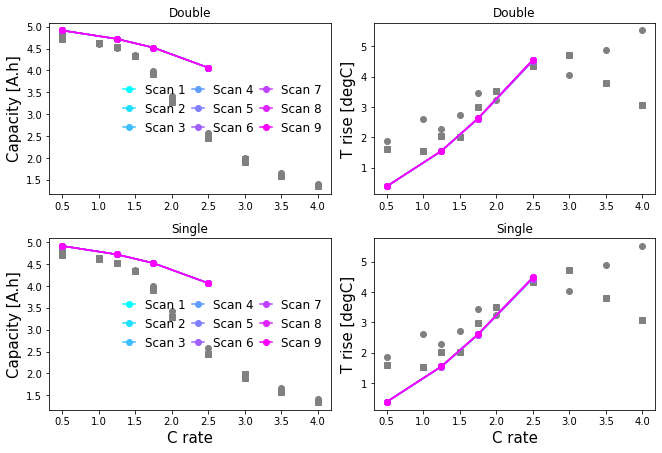

In [9]:
# compare all results - different scans
ls = "-"
# Compare experiment and modelling result: temperature rise and capacity vs C rate
fig, axs = plt.subplots(2,2, figsize=(9.3,6.4),tight_layout=True)
# experiment:
axs[0,0].plot(Ruihe_Crate, RL_Cap_Cell_1 ,linestyle='none',marker ="o", color="gray",) # label="Cell-1"
axs[0,0].plot(Ruihe_Crate, RL_Cap_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Cell-2"
axs[0,0].plot(Niall_Crate[3:], Niall_Cap[3:] ,linestyle='none',marker ="s",color="gray",) # label="Niall"
axs[0,1].plot(Ruihe_Crate, RL_T_Rise_Cell_1 ,linestyle='none',marker ="o",color="gray",)  # label="Bio-Cell-1"
axs[0,1].plot(Ruihe_Crate, RL_T_Rise_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Bio-Cell-2"

axs[1,0].plot(Ruihe_Crate, RL_Cap_Cell_1 ,linestyle='none',marker ="o", color="gray",) # label="Cell-1"
axs[1,0].plot(Ruihe_Crate, RL_Cap_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Cell-2"
axs[1,0].plot(Niall_Crate[3:], Niall_Cap[3:] ,linestyle='none',marker ="s",color="gray",) # label="Niall"
axs[1,1].plot(Ruihe_Crate, RL_T_Rise_Cell_1 ,linestyle='none',marker ="o",color="gray",)  # label="Bio-Cell-1"
axs[1,1].plot(Ruihe_Crate, RL_T_Rise_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Bio-Cell-2"
# simulation - double
cmdd = mpl.cm.get_cmap("cool", len(result_DD)) 
for i in range(len(result_DD)):
    axs[0,0].plot( 
        result_DD[i]["Rate_Dis_All"],result_DD[i]["Cap_Dis_All"],
        linestyle=ls,marker ="o", color=cmdd(i),label=f"Scan {i+1}" )
    axs[0,1].plot( 
        result_DD[i]["Rate_Dis_All"],result_DD[i]["Trise_All"],
        linestyle=ls,marker ="o", color=cmdd(i),label=f"Scan {i+1}" )
# simulation - single
cmsd = mpl.cm.get_cmap("cool", len(result_SD)) 
for i in range(len(result_SD)):
    axs[1,0].plot( 
        result_SD[i]["Rate_Dis_All"],result_SD[i]["Cap_Dis_All"],
        linestyle=ls,marker ="o", color=cmsd(i),label=f"Scan {i+1}" )
    axs[1,1].plot( 
        result_SD[i]["Rate_Dis_All"],result_SD[i]["Trise_All"]  ,
        linestyle=ls,marker ="o", color=cmsd(i),label=f"Scan {i+1}" )

axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-5},
    loc='best',ncol=3,frameon=False,markerscale=1,borderpad=0.2,handlelength=1.0,columnspacing=0.5)
axs[1,0].legend(prop={'family':'DejaVu Sans','size':fs-5},
    loc='best',ncol=3,frameon=False,markerscale=1,borderpad=0.2,handlelength=1.0,columnspacing=0.5)

axs[0,0].set_ylabel("Capacity [A.h]",fontsize=fs-2)
axs[0,1].set_ylabel("T rise [degC]",fontsize=fs-2)
axs[1,0].set_ylabel("Capacity [A.h]",fontsize=fs-2)
axs[1,1].set_ylabel("T rise [degC]",fontsize=fs-2)
axs[1,0].set_xlabel("C rate",fontsize=fs-2)
axs[1,1].set_xlabel("C rate",fontsize=fs-2)
axs[0,0].set_title("Double",loc='center') 
axs[0,1].set_title("Double",loc='center') 
axs[1,0].set_title("Single",loc='center') 
axs[1,1].set_title("Single",loc='center') 
# plt.savefig( BasicPath + Target+ f"0_Summary_Cap_Trise.png", dpi=600)   